In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from torch import nn
from tqdm import tnrange
import torch.nn.functional as F
import torch
from torch.distributions import Categorical

In [6]:
seed = 765
torch.manual_seed(seed)

In [0]:
distribution = np.load('distribution.npy')
DIST_SHAPE = distribution.shape[0]


In [0]:
distribution_ravel = distribution.ravel()
random_samples = np.random.choice(np.arange(len(distribution_ravel)), size=100000, p=distribution_ravel)

x1 = random_samples // DIST_SHAPE
x2 = random_samples % DIST_SHAPE

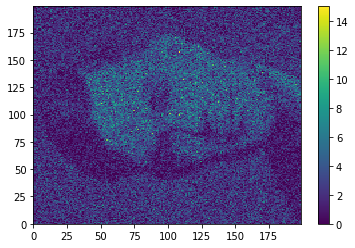

In [9]:
hist_samples = plt.hist2d(x1, x2, bins=200)
plt.colorbar(hist_samples[3])
plt.show()

In [0]:
class Model1(nn.Module):
    def __init__(self, in_features, out_features):
        super(Model1, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.l1 = nn.Sequential(nn.Linear(self.in_features, self.out_features),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.07),
                                 nn.Linear(self.out_features, self.out_features))
        self.l2 = nn.Sequential(nn.Linear(self.in_features, self.out_features),
                                 nn.ReLU(),
                                 nn.Linear(self.out_features, self.out_features))
        
    def to_one_hot(self, x1):
        x = torch.zeros(x1.shape[0], self.in_features)
        v = x1.view(-1, 1).long()
        x.scatter_(1, v, 1)
        return x
    
    def forward(self, x1, x2):
        x = self.to_one_hot(x1)
        v1 = x1.view(-1, 1).long()
        v2 = x2.view(-1, 1).long()

        l1 = self.l1(torch.ones_like(x))
        l2 = self.l2(x)

        p1 = F.softmax(l1, dim=1).gather(1, v1)
        p2 = F.softmax(l2, dim=1).gather(1, v2)
        return p1 * p2

In [0]:
class MaskLinear(torch.nn.Linear):
    def __init__(self, in_features, out_features):
        super(MaskLinear, self).__init__(in_features, out_features)
        self.handle = self.register_backward_hook(lambda module, grad_i, grad_o:
                                  (grad_i[0], grad_i[1], module.mask * grad_i[2]))
        
    def forward(self, x, mask):
        self.mask = mask
        return F.linear(x, self.mask * self.weight, self.bias)

In [0]:
class Model2(nn.Module):
    def __init__(self, in_features, out_features, num_layers=2):
        super(Model2, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.l1 = MaskLinear(self.in_features, self.out_features)
        self.linears = nn.ModuleList()

        for i in range(num_layers):
          self.linears.append(MaskLinear(self.out_features, self.out_features))
    
    def to_one_hot(self, x1):
        x = torch.zeros(x1.shape[0], self.in_features)
        v1 = x1.view(-1, 1).long()
        x.scatter_(1, v1, 1)
        return x
        
    def forward(self, x1, x2):
        x_onehot = self.to_one_hot(x1)
        ones = torch.ones(1)
        x = self.l1(x_onehot, ones)
        x = self.linears[0](F.relu(x), ones)
        relu_x = F.relu(x)

        minw = self.linears[0].weight.min().item()
        maxw = self.linears[0].weight.max().item()

        t = torch.FloatTensor(self.linears[0].weight.shape)
        t = t.uniform_(minw, maxw).detach()
        mask = (t <= self.linears[0].weight)
        mask = mask.float().detach()
        
        x = self.linears[1](relu_x, mask)
        v = x.view(-1, 2, DIST_SHAPE)
        x = F.softmax(v, dim=2)

        v1 = x1.view(-1, 1).long()
        v2 = x2.view(-1, 1).long()

        ct = torch.cat((v1, v2), dim=1)
        ct = ct.view(-1, 2, 1)

        out = x.gather(2, ct).prod(1)
        return out

In [0]:
def NLL_loss(out):
  return -out.log().mean()

In [0]:
samples = np.random.choice(distribution.size, 80000, p=distribution.flatten())
x1 = samples // DIST_SHAPE
x2 = samples % DIST_SHAPE
train_dataset = list(zip(x1, x2))

In [0]:
samples = np.random.choice(distribution.size, 20000, p=distribution.flatten())
x1 = samples // DIST_SHAPE
x2 = samples % DIST_SHAPE
val_dataset = list(zip(x1, x2))

In [0]:
NUM_EPOCHS = 15
LR = 1e-3
BATCH_SIZE = 1024
IN_FEATURES = 200
OUT_FEATURES = 200

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=20000, shuffle=False)

In [100]:
model1 = Model1(IN_FEATURES, OUT_FEATURES)
optimizer = torch.optim.Adam(model1.parameters(), lr=LR)
val_losses1, val_steps1, train_losses1, train_steps1 = [], [], [], []

it = 0
for epoch in range(NUM_EPOCHS):
    for x1, x2 in train_loader:
        it += 1
        x1 = x1.float()
        x2 = x2.float()
        loss = NLL_loss(model1(x1, x2))

        train_steps1.append(it)
        train_losses1.append(loss.item())

        loss.backward()
        optimizer.step()
        model1.zero_grad()

    print(f'EPOCH {epoch} TRAIN LOSS: {loss.item()}')
    
    with torch.no_grad():
      for x1, x2 in val_loader:
          x1 = x1.float()
          x2 = x2.float()
          loss = NLL_loss(model1(x1, x2))

          val_steps1.append(it)
          val_losses1.append(loss.item())

print(f'FINAL VAL LOSS: {loss.item()}')

EPOCH 0 TRAIN LOSS: 10.53960132598877
EPOCH 1 TRAIN LOSS: 10.522945404052734
EPOCH 2 TRAIN LOSS: 10.574479103088379
EPOCH 3 TRAIN LOSS: 10.551424026489258
EPOCH 4 TRAIN LOSS: 10.563116073608398
EPOCH 5 TRAIN LOSS: 10.492857933044434
EPOCH 6 TRAIN LOSS: 10.455161094665527
EPOCH 7 TRAIN LOSS: 10.438761711120605
EPOCH 8 TRAIN LOSS: 10.412139892578125
EPOCH 9 TRAIN LOSS: 10.441171646118164
EPOCH 10 TRAIN LOSS: 10.420318603515625
EPOCH 11 TRAIN LOSS: 10.401779174804688
EPOCH 12 TRAIN LOSS: 10.507871627807617
EPOCH 13 TRAIN LOSS: 10.354084968566895
EPOCH 14 TRAIN LOSS: 10.420178413391113
FINAL VAL LOSS: 10.595480918884277


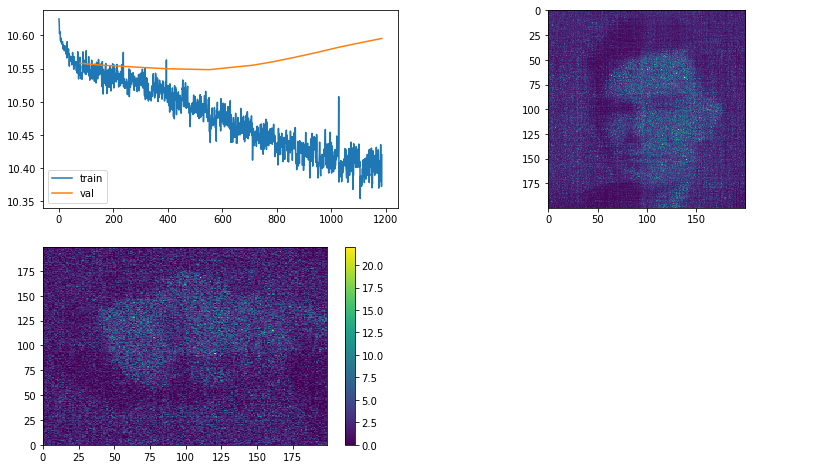

In [101]:
f, axarr = plt.subplots(2, 2, figsize=(14, 8))

ax = axarr[0][0]
ax.plot(train_steps1, train_losses1, label='train')
ax.plot(val_steps1, val_losses1, label='val')
ax.legend()

ax = axarr[0][1]
x = np.arange(distribution.size)
x1 = x // DIST_SHAPE
x2 = x % DIST_SHAPE
x1 = torch.from_numpy(x1).reshape(-1, 1)
x2 = torch.from_numpy(x2).reshape(-1, 1)
probs = model1(x1, x2).detach().numpy()
ax.imshow(probs.reshape(200, 200))

ax = axarr[1][0]
samples = np.random.choice(distribution.size, 100000, p=probs.reshape(-1))
x1 = samples // DIST_SHAPE
x2 = samples % DIST_SHAPE
hist_samples = ax.hist2d(x1, x2, bins=200)
plt.colorbar(hist_samples[3], ax=ax)

axarr[1, 1].axis('off')

plt.show()

In [0]:
NUM_EPOCHS = 25
LR = 1e-3
IN_FEATURES = 200
OUT_FEATURES = 400

In [94]:
model2 = Model2(IN_FEATURES, OUT_FEATURES)
optimizer = torch.optim.Adam(model2.parameters(), lr=LR)
val_losses2, val_steps2, train_losses2, train_steps2 = [], [], [], []

it = 0
for epoch in range(NUM_EPOCHS):
    for x1, x2 in train_loader:
        it += 1
        x1 = x1.float()
        x2 = x2.float()
        loss = NLL_loss(model2(x1, x2))

        train_steps2.append(it)
        train_losses2.append(loss.item())

        loss.backward()
        optimizer.step()
        model2.zero_grad()

    print(f'EPOCH {epoch} TRAIN LOSS: {loss.item()}')

    with torch.no_grad():
      for x1, x2 in val_loader: 
          x1 = x1.float()
          x2 = x2.float()
          loss = NLL_loss(model2(x1, x2))

          val_steps2.append(it)
          val_losses2.append(loss.item())

print(f'FINAL VAL LOSS: {loss.item()}')

EPOCH 0 TRAIN LOSS: 9.110371589660645
EPOCH 1 TRAIN LOSS: 5.4395647048950195
EPOCH 2 TRAIN LOSS: 5.456028461456299
EPOCH 3 TRAIN LOSS: 5.374363422393799
EPOCH 4 TRAIN LOSS: 5.27946662902832
EPOCH 5 TRAIN LOSS: 5.2773661613464355
EPOCH 6 TRAIN LOSS: 5.287265777587891
EPOCH 7 TRAIN LOSS: 5.2359843254089355
EPOCH 8 TRAIN LOSS: 5.289794445037842
EPOCH 9 TRAIN LOSS: 5.277863502502441
EPOCH 10 TRAIN LOSS: 5.220047473907471
EPOCH 11 TRAIN LOSS: 5.20416784286499
EPOCH 12 TRAIN LOSS: 5.231766700744629
EPOCH 13 TRAIN LOSS: 5.226958274841309
EPOCH 14 TRAIN LOSS: 5.20803165435791
EPOCH 15 TRAIN LOSS: 5.278865814208984
EPOCH 16 TRAIN LOSS: 5.170247554779053
EPOCH 17 TRAIN LOSS: 5.191095352172852
EPOCH 18 TRAIN LOSS: 5.156325817108154
EPOCH 19 TRAIN LOSS: 5.176835060119629
EPOCH 20 TRAIN LOSS: 5.15418004989624
EPOCH 21 TRAIN LOSS: 5.143962860107422
EPOCH 22 TRAIN LOSS: 5.188328742980957
EPOCH 23 TRAIN LOSS: 5.133684158325195
EPOCH 24 TRAIN LOSS: 5.204798698425293
FINAL VAL LOSS: 5.360422134399414


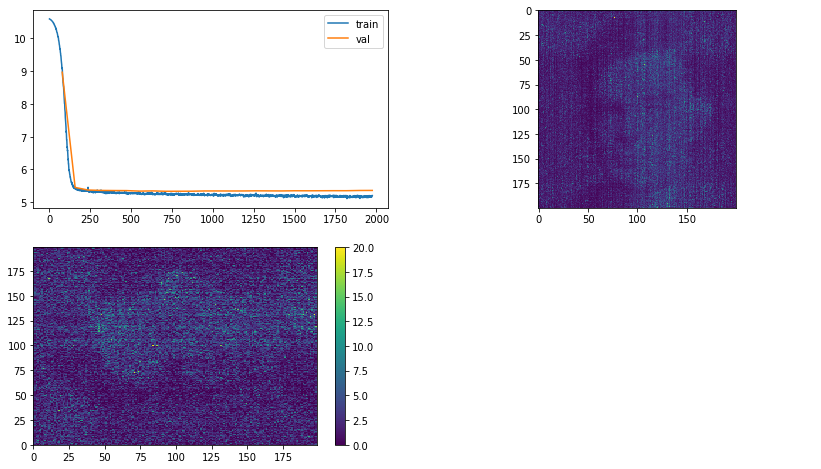

In [95]:
f, axarr = plt.subplots(2, 2, figsize=(14, 8))

ax = axarr[0][0]
ax.plot(train_steps2, train_losses2, label='train')
ax.plot(val_steps2, val_losses2, label='val')
ax.legend()

ax = axarr[0][1]
x = np.arange(distribution.size)
x1 = x // DIST_SHAPE
x2 = x % DIST_SHAPE
x1 = torch.from_numpy(x1).reshape(-1, 1)
x2 = torch.from_numpy(x2).reshape(-1, 1)
probs = model2(x1, x2).detach().numpy()
ax.imshow(probs.reshape(200, 200))

ax = axarr[1][0]
samples = np.random.choice(distribution.size, 100000, p=probs.reshape(-1) / probs.sum())
x1 = samples // DIST_SHAPE
x2 = samples % DIST_SHAPE
hist_samples = ax.hist2d(x1, x2, bins=200)
plt.colorbar(hist_samples[3], ax=ax)

axarr[1, 1].axis('off')

plt.show()